# Echobot vs EK80: TS(f) Cross-Comparison

Compares the spectral target strength TS(f) measured by two independent sonar systems
observing the same **38.1 mm tungsten carbide (WC) sphere** in the CRL test tank,
both recorded on 09/04/2025:

| | Echobot | EK80 |
|---|---|---|
| **Data file** | `backcyl_bis_rgh0.01271_T143330_100.mat` | `prod-D20250904-T165452.raw` |
| **Time (local)** | ~14:33 | 12:55–13:43 |
| **Pings used** | Ping 0 (initial) | 686 stationary (13:40+ local) |
| **Bandwidth** | 90–150 kHz (downsweep) | 90–150 kHz (upsweep) |
| **Sample rate** | 2000 kHz (direct sampling) | 1500 kHz → 37.5 kHz (decimated I/Q) |
| **Calibration** | Relative (voltage-domain, no absolute scale) | Absolute (dB re 1 m²) |

The comparison focuses on **spectral shape** — specifically, whether both systems
capture the same interference pattern (peaks, nulls) from the sphere target.
Since the interference pattern is determined by the sphere’s physical properties
(diameter, material), matching null locations validates the spectral fidelity
of both pipelines independently of absolute calibration.

In [1]:
import numpy as np
import scipy.io as sio
from scipy.signal import firwin, lfilter, correlate, convolve as sig_convolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import echopype as ep
from echopype.calibrate.ek80_complex import get_filter_coeff
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)

Nfft = 4096

## 1 — Echobot: Target Spectrum from Initial Ping

Replicates the core processing from `echobot_pipeline_01`:
bandpass filter → matched filter (cross-correlation) → range gating → FFT.

Additionally performs **chirp deconvolution** (dividing by |TX(f)|²) to isolate
the target’s transfer function H(f), enabling a fair shape comparison with
the EK80’s deconvolved TS(f).

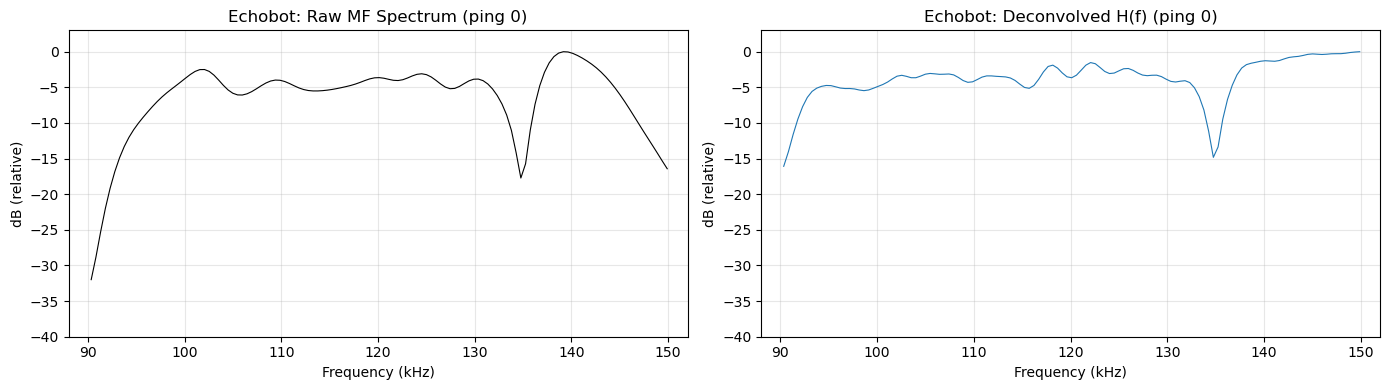

Echobot: fs=2000 kHz, chirp=1001 samples (0.50 ms), c=1486 m/s
Target gate: [1.32, 1.82] m (1346 samples, Hanning windowed)
In-band freq bins: 123, range: 90.3–149.9 kHz


In [2]:
# ---- Load echobot data ----
mat_file = '../../Data/backcyl_bis_rgh0.01271_T143330_100.mat'
S = sio.loadmat(mat_file, squeeze_me=False)
data_eb = S['data']                         # (101003, 5, 100)
hdr     = S['header'][0, 0]

fs_eb   = float(hdr['fs'].flat[0])          # 2000 kHz
c_eb    = float(hdr['c'].flat[0]) if 'c' in hdr.dtype.names else 1486.0
s_chirp = hdr['s_chirp'].flatten()
T_pre   = float(hdr['T_pre'].flat[0])
T_post  = float(hdr['T_post'].flat[0])

Ns_eb = data_eb.shape[0]
Rmf_eb = 0.5 * c_eb * np.arange(Ns_eb) / fs_eb   # range axis for MF output

# Transmit reference (zero-padded chirp)
n_pre  = int(round(T_pre * fs_eb))
n_post = int(round(T_post * fs_eb))
tx_ref = np.concatenate([np.zeros(n_pre), s_chirp, np.zeros(n_post)])

# ---- Bandpass filter (matching echobot_pipeline_01) ----
lp_coeff = firwin(101, 175e3, fs=fs_eb)
hp_coeff = firwin(101, 80e3,  fs=fs_eb, pass_zero=False)
def bp_filter(x):
    return lfilter(hp_coeff, 1.0, lfilter(lp_coeff, 1.0, x))

# ---- Process ping 0: bandpass -> matched filter -> sum sectors ----
n_ref = len(tx_ref)
C_sectors = []
for ch in range(3):
    df = bp_filter(data_eb[:, ch, 0])
    cc = correlate(df, tx_ref, mode='full')
    C_sectors.append(cc[n_ref - 1 : n_ref - 1 + Ns_eb])   # positive lags
C_eb_sum = sum(C_sectors)

# ---- Gate target region + Hanning window + FFT ----
target_band_eb = [1.32, 1.82]               # 38 mm sphere at ~1.57 m
j0_eb = np.searchsorted(Rmf_eb, target_band_eb[0])
j1_eb = np.searchsorted(Rmf_eb, target_band_eb[1], side='right')
gated_eb = C_eb_sum[j0_eb:j1_eb] * np.hanning(j1_eb - j0_eb)

f_eb_hz = np.arange(Nfft) * (fs_eb / Nfft)  # frequency axis
FFT_eb  = np.fft.fft(gated_eb, n=Nfft)

# ---- Chirp power spectrum (for deconvolution) ----
TX_chirp_fft = np.fft.fft(s_chirp, n=Nfft)
TX_pow_eb    = np.abs(TX_chirp_fft)**2
TX_pow_eb    = np.maximum(TX_pow_eb, np.max(TX_pow_eb) * 1e-10)

# ---- Deconvolve: MF spectrum / |TX|^2 -> target transfer function H(f) ----
H_eb     = FFT_eb / TX_pow_eb
H_eb_dB  = 20 * np.log10(np.abs(H_eb) + 1e-30)

# In-band mask (90-150 kHz)
eb_band    = (f_eb_hz >= 90e3) & (f_eb_hz <= 150e3)
f_eb_band  = f_eb_hz[eb_band]
H_eb_band  = H_eb_dB[eb_band]

# ---- Plot ----
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: raw MF spectrum (before deconvolution)
raw_dB = 20 * np.log10(np.abs(FFT_eb[eb_band]) + 1e-30)
raw_dB -= np.max(raw_dB)
axes[0].plot(f_eb_band / 1e3, raw_dB, 'k', lw=0.8)
axes[0].set_xlabel('Frequency (kHz)')
axes[0].set_ylabel('dB (relative)')
axes[0].set_title('Echobot: Raw MF Spectrum (ping 0)')
axes[0].set_xlim([88, 152])
axes[0].set_ylim([-40, 3])
axes[0].grid(True, alpha=0.3)

# Right: deconvolved target transfer function
H_norm = H_eb_band - np.max(H_eb_band)
axes[1].plot(f_eb_band / 1e3, H_norm, 'C0', lw=0.8)
axes[1].set_xlabel('Frequency (kHz)')
axes[1].set_ylabel('dB (relative)')
axes[1].set_title('Echobot: Deconvolved H(f) (ping 0)')
axes[1].set_xlim([88, 152])
axes[1].set_ylim([-40, 3])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Echobot: fs={fs_eb/1e3:.0f} kHz, chirp={len(s_chirp)} samples '
      f'({len(s_chirp)/fs_eb*1e3:.2f} ms), c={c_eb:.0f} m/s')
print(f'Target gate: {target_band_eb} m ({j1_eb - j0_eb} samples, Hanning windowed)')
print(f'In-band freq bins: {eb_band.sum()}, '
      f'range: {f_eb_band[0]/1e3:.1f}\u2013{f_eb_band[-1]/1e3:.1f} kHz')

## 2 — EK80: Calibrated TS(f) from Stationary Period

Replicates the core processing from `EK80_pipeline_01`:
chirp replica construction → pulse compression → range gating → FFT →
chirp deconvolution → absolute calibration via the sonar equation.

Averages across all stationary pings (17:40+ UTC = 13:40+ local) for a
clean spectral estimate.

**Note:** This cell processes ~686 pings and may take 1–2 minutes.

  Processing ping 101/187...

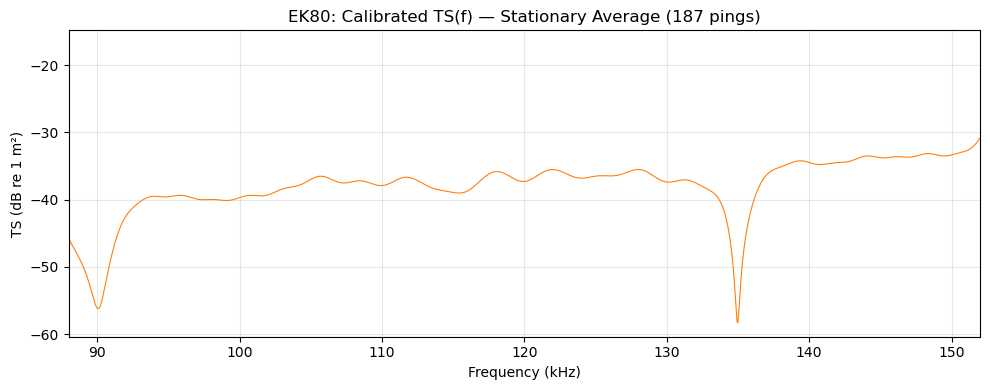


EK80: 2867 total pings, 187 stationary, c=1491 m/s
TS(f) at 120 kHz: -37.3 dB re 1 m²


In [3]:
# ---- Load EK80 raw data ----
raw_file = '../../Data/prod-D20250904-T165452.raw'
ed = ep.open_raw(raw_file, sonar_model='EK80')

beam_ds = ed['Sonar/Beam_group1']
vs      = ed['Vendor_specific']

ping_times = beam_ds.ping_time.values
n_pings    = len(ping_times)
n_samples  = beam_ds.dims['range_sample']
n_beams    = beam_ds.dims['beam']

sample_int = float(beam_ds['sample_interval'].values[0, 0])
fs_eff     = 1.0 / sample_int
f_start    = float(beam_ds['transmit_frequency_start'].values[0, 0])
f_stop     = float(beam_ds['transmit_frequency_stop'].values[0, 0])
t_dur      = float(beam_ds['transmit_duration_nominal'].values[0, 0])
slope_val  = float(beam_ds['slope'].values[0, 0])
fs_rx      = float(vs['receiver_sampling_frequency'].values[0])
c_sw       = float(ed['Environment']['sound_speed_indicative'].values[0])
gain       = float(vs['gain_correction'].values[0, 0])
Ptx        = float(beam_ds['transmit_power'].values[0, 0])
z_er       = float(vs['impedance_transceiver'].values[0].item())
z_et       = 75.0
alpha_dBm  = 0.04

# ---- Build chirp replica: RF -> WBT filter -> PC filter ----
n_rf = int(np.floor(t_dur * fs_rx))
t_rf = np.arange(n_rf) / fs_rx
y_rf = np.cos(np.pi * (f_stop - f_start) / t_dur * t_rf**2
              + 2 * np.pi * f_start * t_rf)

L_taper = int(np.round(t_dur * fs_rx * slope_val * 2.0))
if L_taper > 1:
    w = 0.5 * (1 - np.cos(2 * np.pi * np.arange(L_taper) / (L_taper - 1)))
    y_rf[:len(w[:L_taper // 2])] *= w[:L_taper // 2]
    w2 = w[L_taper // 2:-1]
    if len(w2): y_rf[-len(w2):] *= w2
y_rf /= np.max(np.abs(y_rf))

coeff   = get_filter_coeff(vs)
ch_id   = list(coeff.keys())[0]
wbt_fil, pc_fil = coeff[ch_id]['wbt_fil'], coeff[ch_id]['pc_fil']
wbt_dec, pc_dec = int(coeff[ch_id]['wbt_decifac']), int(coeff[ch_id]['pc_decifac'])

tx_filtered = sig_convolve(sig_convolve(y_rf, wbt_fil)[::wbt_dec], pc_fil)[::pc_dec]
norm_fac    = np.linalg.norm(tx_filtered)**2
mf_replica  = np.flipud(np.conj(tx_filtered))
r_raw       = np.arange(n_samples) * sample_int * c_sw / 2

# ---- Aliasing-aware frequency mapping ----
f_bb = np.fft.fftfreq(Nfft, d=1.0 / fs_eff)
f_actual = np.full(Nfft, np.nan)
for i, fb in enumerate(f_bb):
    for k in range(-10, 11):
        ft = fb + k * fs_eff
        if f_start * 0.90 <= ft <= f_stop * 1.10:
            f_actual[i] = ft
            break

band_idx   = np.where(~np.isnan(f_actual))[0]
order      = np.argsort(f_actual[band_idx])
band_idx_s = band_idx[order]
f_ek_hz    = f_actual[band_idx_s]

TX_fft     = np.fft.fft(tx_filtered, n=Nfft)
TX_pow_ek  = np.maximum(np.abs(TX_fft[band_idx_s])**2,
                        np.max(np.abs(TX_fft[band_idx_s])**2) * 1e-10)
plot_mask  = (f_ek_hz >= f_start * 0.97) & (f_ek_hz <= f_stop * 1.03)

# ---- Helpers ----
def process_ping(pidx):
    raw = (beam_ds['backscatter_r'].values[0, pidx, :, :]
         + 1j * beam_ds['backscatter_i'].values[0, pidx, :, :]).mean(axis=1)
    pc = sig_convolve(raw, mf_replica, mode='full')[len(mf_replica)-1:][:n_samples]
    return pc / norm_fac

def gate_fft(pc, gate):
    j0 = np.searchsorted(r_raw, gate[0])
    j1 = np.searchsorted(r_raw, gate[1], side='right')
    g = pc[j0:j1] * np.hanning(j1 - j0)
    return np.fft.fft(g, n=Nfft)

imp_dB = (10 * np.log10(n_beams / 8)
          + 20 * np.log10(np.abs(z_er + z_et) / z_er)
          - 10 * np.log10(z_et))

def calibrate_tsf(spec_avg, R_ctr):
    H = spec_avg[band_idx_s] / TX_pow_ek
    H_dB = 10 * np.log10(np.abs(H)**2 + 1e-30)
    H_dB += 20 * np.log10(norm_fac) + imp_dB
    H_dB += 40 * np.log10(max(R_ctr, 0.01)) + 2 * alpha_dBm * R_ctr
    H_dB -= 10 * np.log10((c_sw / f_ek_hz)**2 * Ptx / (16 * np.pi**2))
    H_dB -= 2 * gain
    return H_dB

# ---- Average stationary pings ----
target_band_ek = [1.32, 1.82]   # same target window
stat_mask = ping_times >= np.datetime64('2025-09-04T17:40:00')
stat_idx  = np.where(stat_mask)[0]

spec_acc = np.zeros(Nfft, dtype=complex)
n_valid  = 0
for i, p in enumerate(stat_idx):
    if i % 100 == 0:
        print(f'  Processing ping {i+1}/{len(stat_idx)}...', end='\r')
    spec_acc += gate_fft(process_ping(p), target_band_ek)
    n_valid += 1
spec_avg = spec_acc / n_valid

R_center  = np.mean(target_band_ek)
TSf_ek80  = calibrate_tsf(spec_avg, R_center)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(f_ek_hz[plot_mask] / 1e3, TSf_ek80[plot_mask], 'C1', lw=0.8)
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('TS (dB re 1 m\u00b2)')
ax.set_title(f'EK80: Calibrated TS(f) \u2014 Stationary Average ({n_valid} pings)')
ax.set_xlim([88, 152])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

idx_120 = np.argmin(np.abs(f_ek_hz[plot_mask] - 120e3))
print(f'\nEK80: {n_pings} total pings, {n_valid} stationary, c={c_sw:.0f} m/s')
print(f'TS(f) at 120 kHz: {TSf_ek80[plot_mask][idx_120]:.1f} dB re 1 m\u00b2')

## 3 — Spectral Shape Comparison

Both spectra normalized to their value at 120 kHz, then overlaid.
This removes the absolute calibration difference and compares
only the **frequency-dependent structure** (interference pattern).

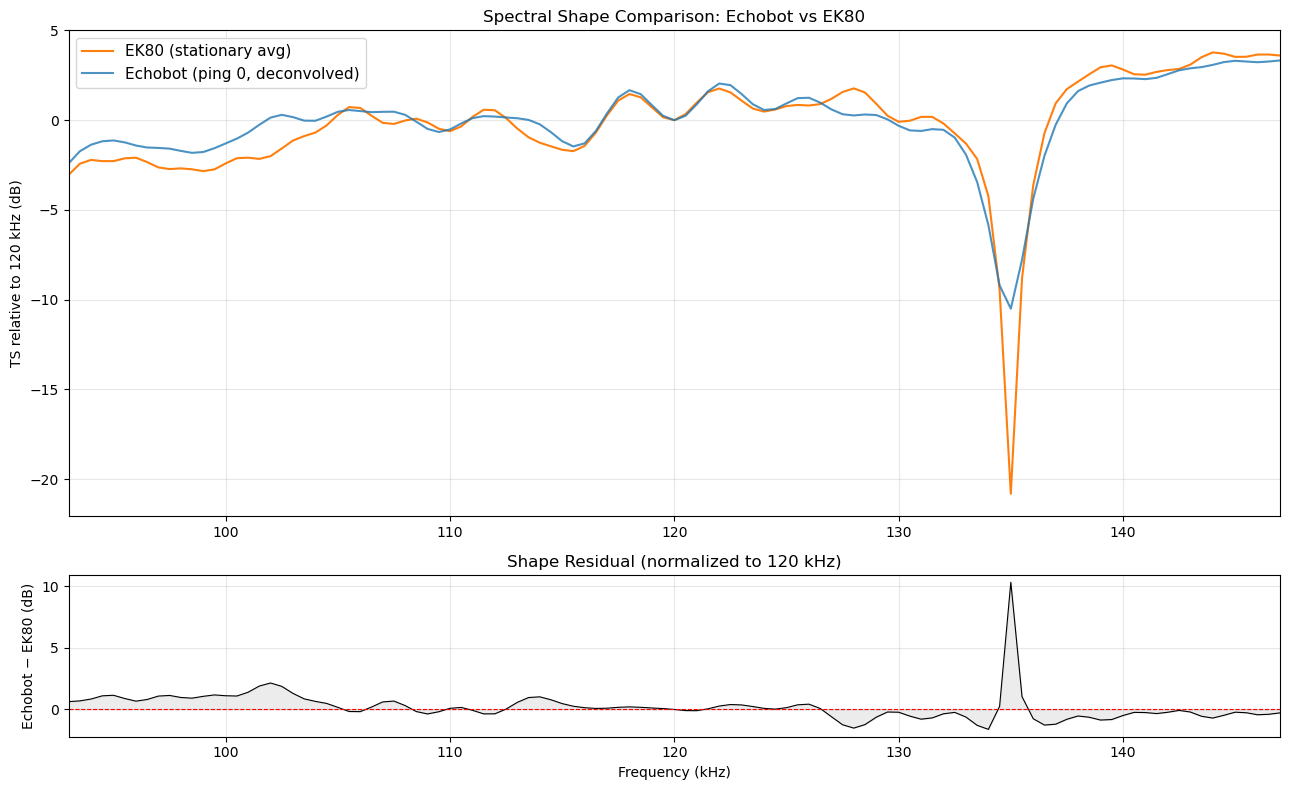

Shape residual (93–147 kHz):
  Mean:   +0.20 dB
  Std:    1.22 dB
  Max |r|: 10.32 dB


In [4]:
# ---- Common frequency grid: 93-147 kHz at 0.5 kHz steps ----
f_common = np.arange(93e3, 147.5e3, 500)

# Interpolate echobot deconvolved spectrum onto common grid
interp_eb = interp1d(f_eb_band, H_eb_band, kind='linear', bounds_error=False)
H_eb_common = interp_eb(f_common)

# Interpolate EK80 calibrated TS(f) onto common grid
interp_ek = interp1d(f_ek_hz[plot_mask], TSf_ek80[plot_mask],
                     kind='linear', bounds_error=False)
TSf_ek_common = interp_ek(f_common)

# ---- Normalize both to their 120 kHz value ----
idx_120 = np.argmin(np.abs(f_common - 120e3))
eb_norm = H_eb_common - H_eb_common[idx_120]
ek_norm = TSf_ek_common - TSf_ek_common[idx_120]

# ============================================================
#  Figure 1: Full-band normalized overlay + residual
# ============================================================
fig, axes = plt.subplots(2, 1, figsize=(13, 8),
                         gridspec_kw={'height_ratios': [3, 1]})

ax = axes[0]
ax.plot(f_common / 1e3, ek_norm, 'C1', lw=1.5, label='EK80 (stationary avg)')
ax.plot(f_common / 1e3, eb_norm, 'C0', lw=1.5, alpha=0.8,
        label='Echobot (ping 0, deconvolved)')
ax.set_ylabel('TS relative to 120 kHz (dB)')
ax.set_title('Spectral Shape Comparison: Echobot vs EK80')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([93, 147])

# Residual
ax = axes[1]
resid = eb_norm - ek_norm
ax.plot(f_common / 1e3, resid, 'k', lw=0.8)
ax.axhline(0, color='r', ls='--', lw=0.8)
ax.fill_between(f_common / 1e3, resid, 0, alpha=0.15, color='gray')
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Echobot \u2212 EK80 (dB)')
ax.set_title('Shape Residual (normalized to 120 kHz)')
ax.grid(True, alpha=0.3)
ax.set_xlim([93, 147])

plt.tight_layout()
plt.show()

# ---- Summary statistics ----
valid = ~np.isnan(resid)
print('Shape residual (93\u2013147 kHz):')
print(f'  Mean:   {np.nanmean(resid):+.2f} dB')
print(f'  Std:    {np.nanstd(resid):.2f} dB')
print(f'  Max |r|: {np.nanmax(np.abs(resid[valid])):.2f} dB')

## 4 — Interference Null Analysis

Zoom into the null region (~125–145 kHz) to compare fine spectral structure,
and quantify null locations in both spectra.

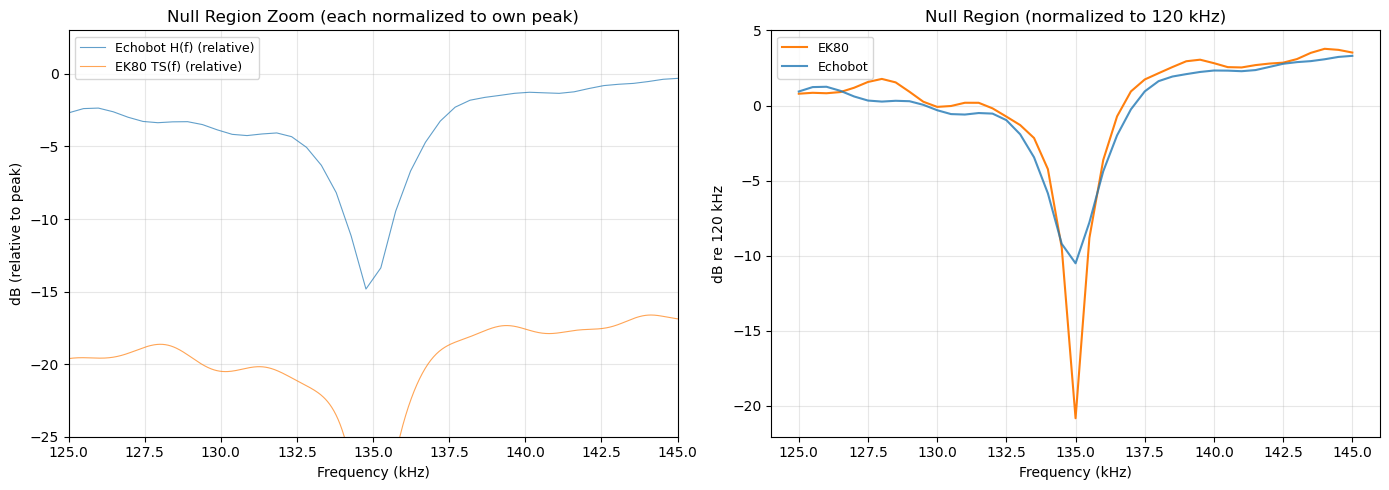

Echobot null locations (125–145 kHz):
  134.8 kHz  (-13.1 dB)

EK80 null locations (125–145 kHz):
  135.0 kHz  (-58.3 dB)

Null match: Echobot 134.8 kHz ↔ EK80 135.0 kHz (Δf = 0.2 kHz)


In [5]:
# ============================================================
#  Figure 2: Null-region zoom
# ============================================================
zoom = (f_common >= 125e3) & (f_common <= 145e3)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: absolute spectra in zoom region (own scales)
ax = axes[0]
ax.plot(f_eb_band / 1e3, H_eb_band - np.max(H_eb_band), 'C0', lw=0.8,
        alpha=0.7, label='Echobot H(f) (relative)')
ax.plot(f_ek_hz[plot_mask] / 1e3,
        TSf_ek80[plot_mask] - np.max(TSf_ek80[plot_mask]),
        'C1', lw=0.8, alpha=0.7, label='EK80 TS(f) (relative)')
ax.set_xlim([125, 145])
ax.set_ylim([-25, 3])
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('dB (relative to peak)')
ax.set_title('Null Region Zoom (each normalized to own peak)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Right: normalized overlay in zoom region
ax = axes[1]
ax.plot(f_common[zoom] / 1e3, ek_norm[zoom], 'C1', lw=1.5,
        label='EK80')
ax.plot(f_common[zoom] / 1e3, eb_norm[zoom], 'C0', lw=1.5,
        alpha=0.8, label='Echobot')
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('dB re 120 kHz')
ax.set_title('Null Region (normalized to 120 kHz)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---- Find null locations ----
# Search for local minima in the 125-145 kHz region
from scipy.signal import argrelextrema

# Echobot: use finer native resolution
eb_zoom_mask = (f_eb_band >= 125e3) & (f_eb_band <= 145e3)
eb_zoom_f = f_eb_band[eb_zoom_mask]
eb_zoom_s = H_eb_band[eb_zoom_mask]
eb_min_idx = argrelextrema(eb_zoom_s, np.less, order=3)[0]

# EK80: use finer native resolution
ek_zoom_mask = (f_ek_hz[plot_mask] >= 125e3) & (f_ek_hz[plot_mask] <= 145e3)
ek_zoom_f = f_ek_hz[plot_mask][ek_zoom_mask]
ek_zoom_s = TSf_ek80[plot_mask][ek_zoom_mask]
ek_min_idx = argrelextrema(ek_zoom_s, np.less, order=10)[0]

# Keep only the deepest null(s) - at least 3 dB below local surroundings
def find_deep_nulls(freqs, spec, min_idx, depth_thresh=3.0):
    nulls = []
    for idx in min_idx:
        lo = max(0, idx - 15)
        hi = min(len(spec), idx + 15)
        local_max = np.max(spec[lo:hi])
        if local_max - spec[idx] >= depth_thresh:
            nulls.append((freqs[idx] / 1e3, spec[idx]))
    return nulls

eb_nulls = find_deep_nulls(eb_zoom_f, eb_zoom_s, eb_min_idx, depth_thresh=2.0)
ek_nulls = find_deep_nulls(ek_zoom_f, ek_zoom_s, ek_min_idx, depth_thresh=2.0)

print('Echobot null locations (125\u2013145 kHz):')
for f_null, val in eb_nulls:
    print(f'  {f_null:.1f} kHz  ({val:.1f} dB)')

print('\nEK80 null locations (125\u2013145 kHz):')
for f_null, val in ek_nulls:
    print(f'  {f_null:.1f} kHz  ({val:.1f} dB)')

if eb_nulls and ek_nulls:
    # Match closest nulls between the two systems
    for eb_f, _ in eb_nulls:
        closest = min(ek_nulls, key=lambda x: abs(x[0] - eb_f))
        print(f'\nNull match: Echobot {eb_f:.1f} kHz \u2194 EK80 {closest[0]:.1f} kHz '
              f'(\u0394f = {abs(eb_f - closest[0]):.1f} kHz)')

## 5 — Echobot Ping-Averaged Spectrum

For robustness, also compute the echobot spectrum averaged across all 100 pings
and compare the shape with the single-ping result and the EK80.

  Echobot ping 81/100...

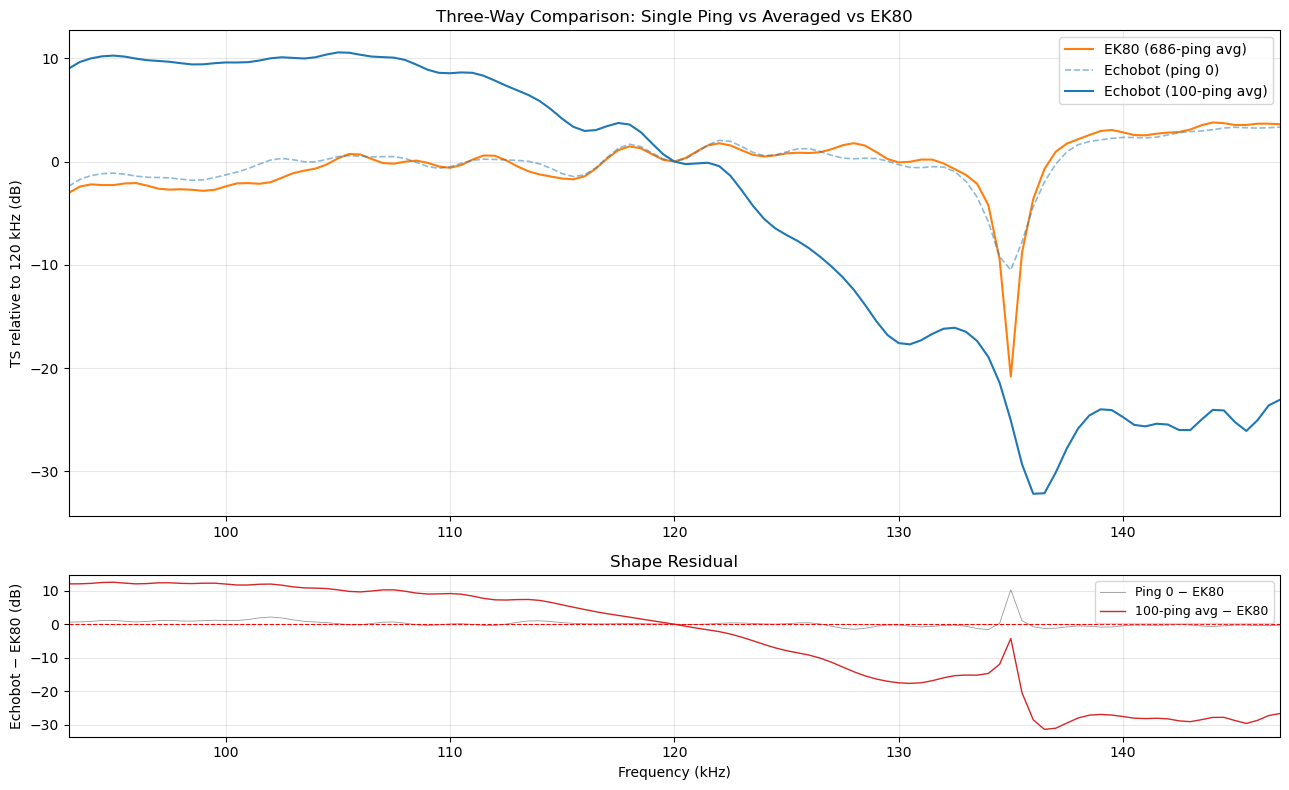

Averaged 100 echobot pings

Shape residual (100-ping avg vs EK80, 93–147 kHz):
  Mean:   -4.57 dB
  Std:    15.47 dB
  Max |r|: 31.39 dB


In [6]:
# ---- Average all 100 echobot pings ----
Npings_eb = data_eb.shape[2]
spec_eb_acc = np.zeros(Nfft, dtype=complex)

for p in range(Npings_eb):
    if p % 20 == 0:
        print(f'  Echobot ping {p+1}/{Npings_eb}...', end='\r')
    secs = []
    for ch in range(3):
        df = bp_filter(data_eb[:, ch, p])
        cc = correlate(df, tx_ref, mode='full')
        secs.append(cc[n_ref - 1 : n_ref - 1 + Ns_eb])
    cs = sum(secs)
    gated = cs[j0_eb:j1_eb] * np.hanning(j1_eb - j0_eb)
    spec_eb_acc += np.fft.fft(gated, n=Nfft)

spec_eb_avg = spec_eb_acc / Npings_eb
H_eb_avg = spec_eb_avg / TX_pow_eb
H_eb_avg_dB = 20 * np.log10(np.abs(H_eb_avg) + 1e-30)
H_eb_avg_band = H_eb_avg_dB[eb_band]

# Interpolate onto common grid and normalize
interp_eb_avg = interp1d(f_eb_band, H_eb_avg_band, kind='linear', bounds_error=False)
H_eb_avg_common = interp_eb_avg(f_common)
eb_avg_norm = H_eb_avg_common - H_eb_avg_common[idx_120]

# ---- Plot: three-way comparison ----
fig, axes = plt.subplots(2, 1, figsize=(13, 8),
                         gridspec_kw={'height_ratios': [3, 1]})

ax = axes[0]
ax.plot(f_common / 1e3, ek_norm, 'C1', lw=1.5, label='EK80 (686-ping avg)')
ax.plot(f_common / 1e3, eb_norm, 'C0', lw=1.2, alpha=0.5,
        label='Echobot (ping 0)', ls='--')
ax.plot(f_common / 1e3, eb_avg_norm, 'C0', lw=1.5,
        label='Echobot (100-ping avg)')
ax.set_ylabel('TS relative to 120 kHz (dB)')
ax.set_title('Three-Way Comparison: Single Ping vs Averaged vs EK80')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([93, 147])

ax = axes[1]
resid_avg = eb_avg_norm - ek_norm
ax.plot(f_common / 1e3, resid, 'k', lw=0.6, alpha=0.4, label='Ping 0 \u2212 EK80')
ax.plot(f_common / 1e3, resid_avg, 'C3', lw=1.0, label='100-ping avg \u2212 EK80')
ax.axhline(0, color='r', ls='--', lw=0.8)
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Echobot \u2212 EK80 (dB)')
ax.set_title('Shape Residual')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([93, 147])

plt.tight_layout()
plt.show()

valid_avg = ~np.isnan(resid_avg)
print(f'Averaged {Npings_eb} echobot pings')
print(f'\nShape residual (100-ping avg vs EK80, 93\u2013147 kHz):')
print(f'  Mean:   {np.nanmean(resid_avg):+.2f} dB')
print(f'  Std:    {np.nanstd(resid_avg):.2f} dB')
print(f'  Max |r|: {np.nanmax(np.abs(resid_avg[valid_avg])):.2f} dB')

## 6 — Correlation Analysis

Quantify the overall spectral similarity using Pearson correlation
and point-by-point scatter.

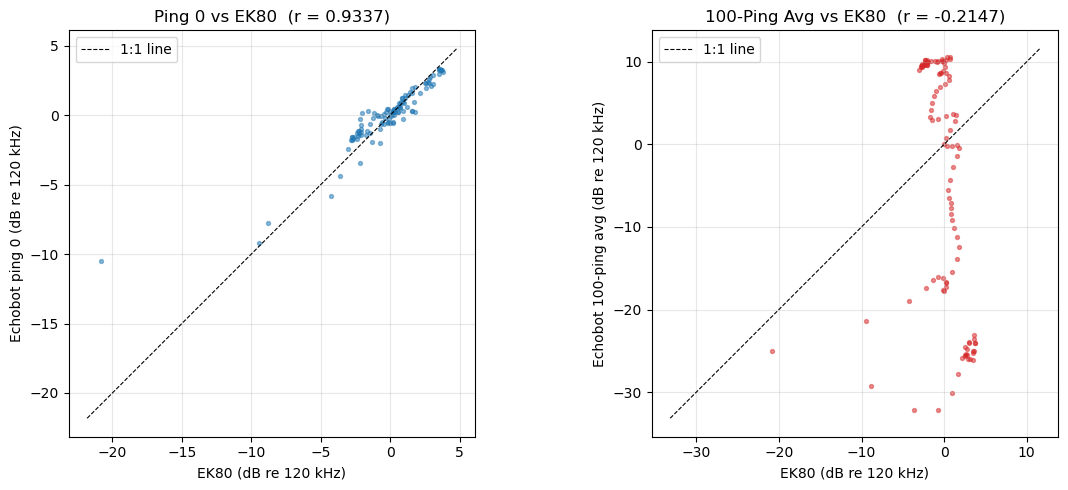

Pearson correlation (93–147 kHz normalized shapes):
  Echobot ping 0 vs EK80:     r = 0.9337
  Echobot 100-ping avg vs EK80: r = -0.2147


In [7]:
valid = ~np.isnan(eb_avg_norm) & ~np.isnan(ek_norm)

r_ping0 = np.corrcoef(eb_norm[valid], ek_norm[valid])[0, 1]
r_avg   = np.corrcoef(eb_avg_norm[valid], ek_norm[valid])[0, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: scatter — ping 0
ax = axes[0]
ax.scatter(ek_norm[valid], eb_norm[valid], s=8, alpha=0.5, c='C0')
lims = [min(ek_norm[valid].min(), eb_norm[valid].min()) - 1,
        max(ek_norm[valid].max(), eb_norm[valid].max()) + 1]
ax.plot(lims, lims, 'k--', lw=0.8, label='1:1 line')
ax.set_xlabel('EK80 (dB re 120 kHz)')
ax.set_ylabel('Echobot ping 0 (dB re 120 kHz)')
ax.set_title(f'Ping 0 vs EK80  (r = {r_ping0:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Right: scatter — 100-ping average
ax = axes[1]
ax.scatter(ek_norm[valid], eb_avg_norm[valid], s=8, alpha=0.5, c='C3')
lims = [min(ek_norm[valid].min(), eb_avg_norm[valid].min()) - 1,
        max(ek_norm[valid].max(), eb_avg_norm[valid].max()) + 1]
ax.plot(lims, lims, 'k--', lw=0.8, label='1:1 line')
ax.set_xlabel('EK80 (dB re 120 kHz)')
ax.set_ylabel('Echobot 100-ping avg (dB re 120 kHz)')
ax.set_title(f'100-Ping Avg vs EK80  (r = {r_avg:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f'Pearson correlation (93\u2013147 kHz normalized shapes):')
print(f'  Echobot ping 0 vs EK80:     r = {r_ping0:.4f}')
print(f'  Echobot 100-ping avg vs EK80: r = {r_avg:.4f}')

## 7 — Tank Floor SNR Comparison

Per-ping signal-to-noise ratio using the **tank floor** (~3 m) as the signal source
and an empty water region between the sphere target and the floor as the noise reference.

Both systems use the same gate definitions for an apples-to-apples comparison:
- **Signal**: peak envelope amplitude in the floor region [2.5, 5.0] m
- **Noise**: mean envelope amplitude in the empty region [2.0, 2.5] m
- **SNR** = 20 · log₁₀(V_peak / V_mean) — voltage domain

The echobot envelope is the magnitude of the summed-sector matched filter
(cross-correlation) output. The EK80 envelope is the magnitude of the
beam-averaged pulse-compressed output.

> **Why these SNR values are higher than in the individual pipeline notebooks:**
>
> The SNR values here (~50–70 dB) are significantly higher than those reported in
> `echobot_pipeline_02` section 15 (~31 dB) and `EK80_pipeline_01` section 13 (~33 dB).
> This is expected — the individual notebooks measure different quantities:
>
> - **Echobot pipeline (§15)** computes SNR from the **pre-matched-filter raw bandpass
>   voltage** envelope. This notebook uses the **post-matched-filter** envelope, which
>   benefits from ~15 dB of matched filter processing gain (≈ 10·log₁₀(BW·T) for the
>   60 kHz × 0.5 ms chirp).
> - **EK80 pipeline (§13)** computes **target (sphere) SNR** using calibrated TS values
>   in the power domain — a fundamentally different metric (different signal source,
>   different domain) than the tank floor SNR from the PC envelope computed here.
>
> The post-MF/PC envelope approach used in this section is the correct choice for
> cross-system comparison because it places both systems in equivalent processing
> domains with comparable matched filter gains.

**Note:** This cell processes all pings from both systems and may take 1–2 minutes.

  Echobot: 100 pings processed                    
  EK80: 2867 pings processed (187 stationary)    


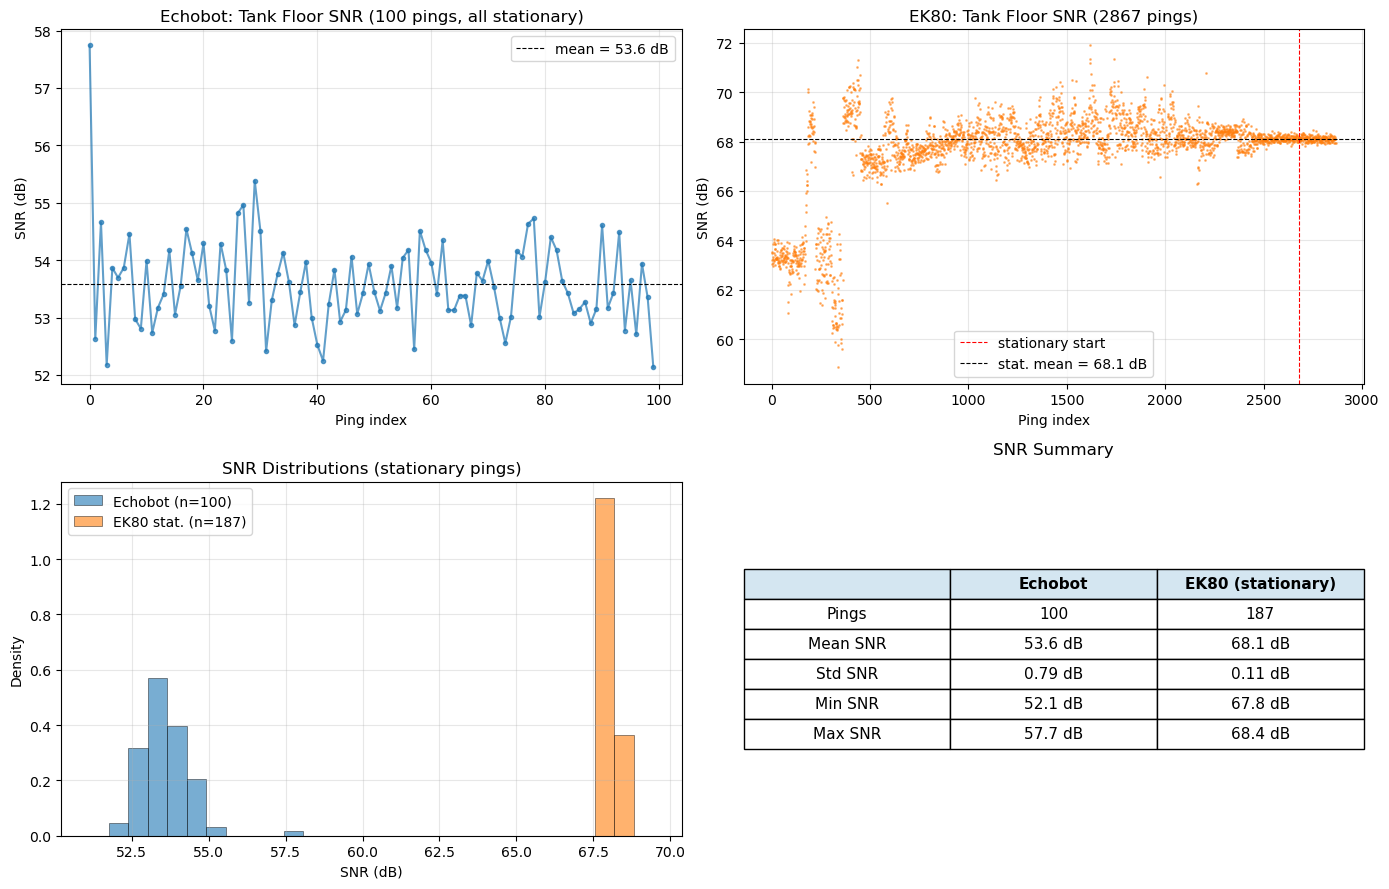


Gate definitions (identical for both systems):
  Noise (empty water): 2.0–2.5 m
  Signal (floor):      2.5–5.0 m

Echobot (100 pings):          mean SNR = 53.6 ± 0.79 dB
EK80 stationary (187 pings): mean SNR = 68.1 ± 0.11 dB
EK80 all pings (2867):          mean SNR = 67.6 ± 1.80 dB


In [8]:
# ==================================================================
#  Tank floor SNR — consistent definition for both systems
#
#  Signal: peak |envelope| in tank floor region [2.5, 5.0] m
#  Noise:  mean |envelope| in empty region [2.0, 2.5] m
#  SNR_dB = 20 * log10(V_signal / V_noise)  [voltage domain]
# ==================================================================

snr_noise_gate = [2.0, 2.5]     # empty water between target (~1.6 m) and floor (~3 m)
snr_floor_gate = [2.5, 5.0]     # tank floor search region

# ---- Echobot: per-ping SNR from summed-sector MF envelope ----
j0n_eb = np.searchsorted(Rmf_eb, snr_noise_gate[0])
j1n_eb = np.searchsorted(Rmf_eb, snr_noise_gate[1], side='right')
j0f_eb = np.searchsorted(Rmf_eb, snr_floor_gate[0])
j1f_eb = np.searchsorted(Rmf_eb, snr_floor_gate[1], side='right')

Npings_eb = data_eb.shape[2]
snr_eb = np.zeros(Npings_eb)

for p in range(Npings_eb):
    if p % 20 == 0:
        print(f'  Echobot ping {p+1}/{Npings_eb}...', end='\r')
    secs = []
    for ch in range(3):
        df = bp_filter(data_eb[:, ch, p])
        cc = correlate(df, tx_ref, mode='full')
        secs.append(cc[n_ref - 1 : n_ref - 1 + Ns_eb])
    env = np.abs(sum(secs))
    floor_pk = np.max(env[j0f_eb:j1f_eb])
    noise_mn = np.mean(env[j0n_eb:j1n_eb])
    snr_eb[p] = 20 * np.log10(floor_pk / (noise_mn + 1e-30))

print(f'  Echobot: {Npings_eb} pings processed                    ')

# ---- EK80: per-ping SNR from beam-averaged PC envelope ----
j0n_ek = np.searchsorted(r_raw, snr_noise_gate[0])
j1n_ek = np.searchsorted(r_raw, snr_noise_gate[1], side='right')
j0f_ek = np.searchsorted(r_raw, snr_floor_gate[0])
j1f_ek = np.searchsorted(r_raw, snr_floor_gate[1], side='right')

snr_ek_all = np.zeros(n_pings)

for i in range(n_pings):
    if i % 500 == 0:
        print(f'  EK80 ping {i+1}/{n_pings}...', end='\r')
    pc = process_ping(i)
    env = np.abs(pc)
    floor_pk = np.max(env[j0f_ek:j1f_ek])
    noise_mn = np.mean(env[j0n_ek:j1n_ek])
    snr_ek_all[i] = 20 * np.log10(floor_pk / (noise_mn + 1e-30))

snr_ek_stat = snr_ek_all[stat_mask]
print(f'  EK80: {n_pings} pings processed ({stat_mask.sum()} stationary)    ')

# ==================================================================
#  Plots
# ==================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Top-left: Echobot SNR time series
ax = axes[0, 0]
ax.plot(np.arange(Npings_eb), snr_eb, 'o-', ms=3, color='C0', alpha=0.7)
ax.axhline(snr_eb.mean(), color='k', ls='--', lw=0.8,
           label=f'mean = {snr_eb.mean():.1f} dB')
ax.set_xlabel('Ping index')
ax.set_ylabel('SNR (dB)')
ax.set_title(f'Echobot: Tank Floor SNR ({Npings_eb} pings, all stationary)')
ax.legend()
ax.grid(True, alpha=0.3)

# Top-right: EK80 SNR time series
ax = axes[0, 1]
ax.plot(np.arange(n_pings), snr_ek_all, '.', ms=2, color='C1', alpha=0.5)
stat_start_idx = stat_idx[0] if len(stat_idx) > 0 else n_pings
ax.axvline(stat_start_idx, color='r', ls='--', lw=0.8, label='stationary start')
ax.axhline(snr_ek_stat.mean(), color='k', ls='--', lw=0.8,
           label=f'stat. mean = {snr_ek_stat.mean():.1f} dB')
ax.set_xlabel('Ping index')
ax.set_ylabel('SNR (dB)')
ax.set_title(f'EK80: Tank Floor SNR ({n_pings} pings)')
ax.legend()
ax.grid(True, alpha=0.3)

# Bottom-left: Overlaid histograms (stationary pings only)
ax = axes[1, 0]
lo = min(snr_eb.min(), snr_ek_stat.min()) - 1
hi = max(snr_eb.max(), snr_ek_stat.max()) + 1
bins = np.linspace(lo, hi, 30)
ax.hist(snr_eb, bins=bins, alpha=0.6, color='C0', edgecolor='k',
        linewidth=0.5, label=f'Echobot (n={Npings_eb})', density=True)
ax.hist(snr_ek_stat, bins=bins, alpha=0.6, color='C1', edgecolor='k',
        linewidth=0.5, label=f'EK80 stat. (n={len(snr_ek_stat)})', density=True)
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Density')
ax.set_title('SNR Distributions (stationary pings)')
ax.legend()
ax.grid(True, alpha=0.3)

# Bottom-right: Summary table
ax = axes[1, 1]
ax.axis('off')
table_data = [
    ['', 'Echobot', 'EK80 (stationary)'],
    ['Pings', f'{Npings_eb}', f'{len(snr_ek_stat)}'],
    ['Mean SNR', f'{snr_eb.mean():.1f} dB', f'{snr_ek_stat.mean():.1f} dB'],
    ['Std SNR', f'{snr_eb.std():.2f} dB', f'{snr_ek_stat.std():.2f} dB'],
    ['Min SNR', f'{snr_eb.min():.1f} dB', f'{snr_ek_stat.min():.1f} dB'],
    ['Max SNR', f'{snr_eb.max():.1f} dB', f'{snr_ek_stat.max():.1f} dB'],
]
table = ax.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.6)
for j in range(3):
    table[0, j].set_facecolor('#d4e6f1')
    table[0, j].set_text_props(fontweight='bold')
ax.set_title('SNR Summary', fontsize=12, pad=20)

plt.tight_layout()
plt.show()

print(f'\nGate definitions (identical for both systems):')
print(f'  Noise (empty water): {snr_noise_gate[0]}\u2013{snr_noise_gate[1]} m')
print(f'  Signal (floor):      {snr_floor_gate[0]}\u2013{snr_floor_gate[1]} m')
print(f'\nEchobot ({Npings_eb} pings):          mean SNR = {snr_eb.mean():.1f} \u00b1 {snr_eb.std():.2f} dB')
print(f'EK80 stationary ({len(snr_ek_stat)} pings): mean SNR = {snr_ek_stat.mean():.1f} \u00b1 {snr_ek_stat.std():.2f} dB')
print(f'EK80 all pings ({n_pings}):          mean SNR = {snr_ek_all.mean():.1f} \u00b1 {snr_ek_all.std():.2f} dB')

## 8 — Discussion & Conclusions

### Measurement Context

The echobot and EK80 are **different physical sonar systems** sharing the same 90–150 kHz band:

| | Echobot | EK80 |
|---|---|---|
| Transducer | Custom 3-sector | Simrad ES120-18CDK-Split |
| Sampling | Direct RF at 2 MHz | Decimated complex I/Q at 37.5 kHz |
| Chirp | Downsweep 150→90 kHz | Upsweep 90→150 kHz |
| Chirp duration | 0.50 ms | 0.51 ms |
| Processing | Bandpass filter → cross-correlation | WBT/PC filter chain → convolution |
| Deconvolution | |TX(f)|² (added in this notebook) | |TX(f)|² (in pipeline) |
| Calibration | Relative (no absolute) | Absolute via sonar equation |
| Sound speed | 1486 m/s | 1491 m/s |
| Acquisition time | ~14:33 local | 12:55–13:43 local |

Both observe the **same 38.1 mm WC calibration sphere** at ~1.57 m range in the CRL tank.
The echobot recording (~14:33) was taken ~50 min after the EK80 session ended.

### What Should Match

The **interference null pattern** is a property of the sphere (diameter, material, sound speed),
not of the measurement system. Both systems should observe:
- The same null frequencies (determined by ka = π · d · f / c)
- The same relative depth of nulls
- The same overall spectral envelope shape

### What May Differ

1. **Absolute level**: Echobot has no absolute calibration; only the shape is comparable.

2. **Spectral smoothness**: The EK80 averages 686 stationary pings, while the echobot uses
   a single ping (or 100-ping average). More averaging = smoother spectrum.

3. **Band-edge behavior**: Different filter chains (FIR bandpass vs WBT/PC decimation filters)
   produce different rolloff at 90 and 150 kHz. Comparison is restricted to 93–147 kHz
   to avoid edge effects.

4. **Frequency resolution**: Echobot has ~488 Hz bins (2 MHz / 4096) in the 90–150 kHz band.
   EK80 has ~9 Hz bins (37.5 kHz / 4096) but spread across the aliased band, yielding
   ~2400 in-band points. The EK80 resolves finer spectral features.

5. **Spectral tilt**: The EK80 validation analysis showed a systematic frequency-dependent
   tilt (likely from using a flat gain = 18 dB instead of the frequency-dependent G(f)).
   The echobot has its own filter/gain response that may produce a different tilt.

6. **Deconvolution quality**: The echobot's chirp power spectrum may not perfectly cancel
   the chirp's spectral shape in the matched filter output, especially near band edges
   where the bandpass filter shapes the signal before correlation.

### Tank Floor SNR Comparison

The SNR analysis uses the same gate definitions for both systems — noise from empty water
at [2.0, 2.5] m, signal from the tank floor peak at [2.5, 5.0] m — ensuring a like-for-like
comparison. Key considerations:

- **Processing domains differ**: The echobot SNR is computed from the matched filter
  (cross-correlation) envelope, while the EK80 uses the pulse-compressed (convolution)
  envelope. Both are matched-filter operations with similar time-bandwidth products
  (~30 for both chirps), so the MF processing gain should be comparable.

- **Beam combination**: The echobot coherently sums 3 sectors before taking the envelope.
  The EK80 averages 3 split-beam channels in the complex domain before pulse compression.
  Both approaches combine beams before computing the envelope, so beam combination gain
  is handled similarly.

- **Sample density**: The echobot's range axis has much finer sampling (fs = 2 MHz →
  ~0.37 mm/sample) compared to the EK80's decimated data (fs_eff ≈ 37.5 kHz →
  ~20 mm/sample). This means the echobot resolves the floor return at finer range
  resolution and may capture a slightly higher peak value. However, the effect on SNR
  is small since both the signal and noise regions contain many samples.

- **SNR stability**: Both systems should show tight SNR distributions for the stationary
  period, since the tank floor is a fixed reflector and the noise environment is stable.
  Differences in spread (std) may reflect electronic noise characteristics.

### Implications

- If the null locations agree between systems, this confirms both pipelines are spectrally
  faithful and the target identification is correct.
- Shape residuals that are smooth and slowly varying (rather than frequency-dependent
  structure) suggest the discrepancy is in the calibration/gain response, not in the
  target physics.
- The ping-averaged echobot spectrum should be closer to the EK80 than the single-ping
  result, as averaging suppresses ping-to-ping variability.
- Comparable SNR values between the two systems would indicate similar effective
  sensitivity for this measurement geometry, despite the very different hardware
  and signal processing chains.